<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [38]:
%%capture
pip install pyswarms

In [39]:
%%capture
pip install scipy

In [40]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_pso_primeiro_cenario'
NOME_ARQUIVO_TEMPO_SEVERIDADE = 'tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '01'

In [43]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [44]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [45]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [46]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [47]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [48]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [49]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [50]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [51]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [52]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [53]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [54]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-11-12 19:17:42,702 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-2.17e-24
2023-11-12 19:17:43,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.169700854119875e-24, best pos: [123.96590232   1.99912612   0.20773614]


In [55]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 123.965902320067
beta: 1.9991261180692197
theta: 0.20773614360492756

Tempo de Convergência para a primeira etapa: 0.02027726173400879 segundos


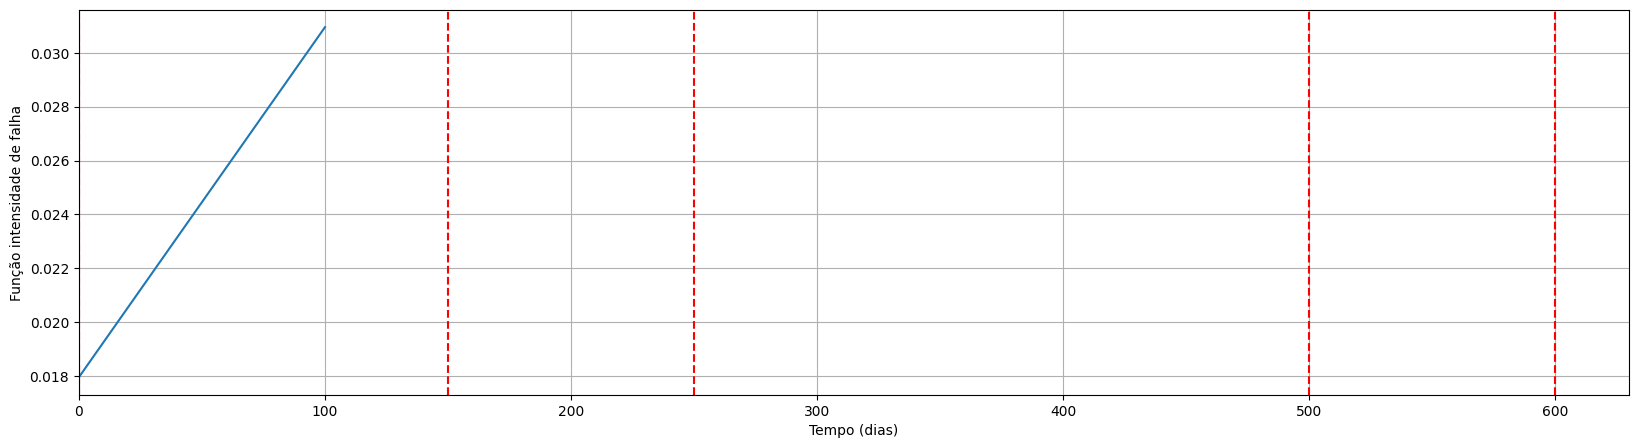

Fator ajuste:  [0.0797357826893037, 0.09865579770645216, 0.17052518314879428, 0.040695972430691674]


In [56]:
# lamb = 149.14151188589648
# beta = 1.0024136102117993
# theta = 0.6353808841179692

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [57]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [83]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-11-12 19:20:29,660 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=2.14e+3<ipython-input-57-c2968896f09c>:80: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=1.82e+3



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 207, 275, 355, 418, 423, 458, 589, 618, 658]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675]
Media de falhas:  [0, 2.787029807293998, 4.843248176191851, 7.706553759916412, 10.451984045150875, 10.711468103040541, 12.437544750240564, 20.95334333051475, 23.008192484059517, 26.00673966345915, 31.610082452549612]
Custo =  3538.0532651703516


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 27, 43, 117, 165, 273, 311, 352, 376, 444, 470, 482]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.0506085094685396

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=1.82e+3



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 57, 181, 240, 317, 352, 381, 520, 540, 653]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.2115631824428604, 2.0937365568194752, 3.5717311044076885, 6.013109227671232, 7.392637675742286, 8.582717158639616, 16.371557122389063, 17.553954295830806, 25.16768020978283, 31.44006018684126]
Custo =  2915.5715881432598


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 25, 50, 118, 124, 209, 238, 317, 357, 384, 621, 649]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.098

pyswarms.single.global_best:  40%|████      |40/100, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 45, 76, 119, 126, 269, 317, 356, 382, 620, 655]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.050608509468539675, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.13188795133476275, 0.36863425083331663, 0.8722217856869965, 0.9782935268623848, 4.419768534772662, 6.005990529449584, 7.630452421822417, 8.703913118883744, 23.598932057291364, 26.091006933196542, 31.917433408336173]
Custo =  4511.386021618028


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 50, 83, 122, 176, 317, 355, 381, 510, 541, 600, 656]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 

pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=1.82e+3

Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.037535408700607543, 0.1930438609660736, 0.2269403799033127, 0.9592539747398059, 6.318391988490244, 7.7522039882910425, 8.908763151203798, 23.521534507415318, 26.00194617146785, 32.66885663057496]
Custo =  2999.5947175787446


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 20, 52, 127, 317, 355, 383, 619, 651]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.1726998472888097, 0.9961129670630707, 6.170992472933722, 7.60480447

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 50, 67, 126, 158, 239, 317, 354, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.009389537966486049, 0.16039457484115568, 0.27894428619125955, 0.9690482058805142, 1.5335756840521544, 3.384417691564069, 5.964356179328249, 7.500707364653579, 8.654154858408424, 26.277271152537487, 32.177874157996676]
Custo =  2901.701544710059


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 53, 65, 123, 239, 317, 355, 382, 571, 617, 654]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  

pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=1.82e+3



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 50, 87, 157, 180, 317, 355, 383, 524, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.1628096402722007, 0.48289321012798214, 1.5157482289771889, 1.996020423227898, 5.959886355375573, 7.4650626786270715, 8.621621841539827, 16.575596792633423, 25.172056541761556, 31.146743728146298]
Custo =  2648.3969840687228


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 48, 81, 122, 198, 317, 355, 383, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.050608509468539675, 0.144271484

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.82e+3
2023-11-12 19:20:31,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60882298 3.78441494 0.73398777 3.86459972 5.31236456 1.62741624
 1.53307276 1.88741294 2.43031188 4.52743882 5.58288965 1.76176704
 5.75459193 6.39815253 2.65247636 2.55218026 0.79014769 5.4833696
 2.70441365 4.28895848 6.52833023 3.79964404 0.16715355 6.3485949 ]
2023-11-12 19:20:31,058 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 14, 54, 60, 119, 121, 167, 183, 238, 317, 356, 382, 514, 607, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.050608509468539675, 0.09865579770645216, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.012778482955465848, 0.1869227780669852, 0.22728537072800545, 0.8689898916740417, 0.8986461962688558, 1.6888654382618657, 2.002908559126154, 3.3196385027632815, 6.045875473208055, 7.670337365580888, 8.743798062642215, 16.09668478609748, 21.973516699980582, 25.380558952141136, 31.652938929199568]
Custo =  10047.275297727085


Número de ciclos de manutenção: 11 5
Temp

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59456399 3.78442534 0.73401005 3.8645986  5.31236443 1.68955829
 1.53150656 1.88741493 2.4304204  4.52850687 5.58286208 1.76128048
 5.75417157 6.3980002  2.65259498 2.55174318 0.79012326 5.48337045
 2.70519331 4.2890855  6.52816501 3.79821169 0.16731142 6.34925832]
2023-11-12 19:20:31,096 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 16, 52, 126, 317, 356, 382, 510, 612, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.016688315967621034, 0.1730385581922791, 0.9806626744597657, 6.172817531992743, 7.646893983896214, 8.720354680957541, 15.817190700621676, 22.27700879021975, 25.324399919094986, 31.596779896153418]
Custo =  2907.4134638425166


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,108 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6165101  3.78443004 0.73397656 3.86461202 5.31235815 1.65249675
 1.53166951 1.88741102 2.4303047  4.52631366 5.58288659 1.7605556
 5.75429247 6.39798977 2.65259194 2.55162088 0.79011961 5.48340141
 2.70583829 4.28912866 6.52818185 3.79801714 0.16732353 6.34951692]
2023-11-12 19:20:31,110 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 17, 51, 128, 238, 317, 357, 382, 530, 610, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.16632332859356325, 1.012680469019508, 3.44992676427462, 5.947415912190989, 7.616127947244795, 8.649456648270291, 17.047316724653264, 22.177346264024514, 25.368910420988627, 31.641290398047058]
Custo =  3150.0989326644735


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 18, 50, 130, 236, 317, 356, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.15975935515290557, 1.0453162898304156, 3.391220351202265, 5.94445079784698, 7.568912690219813, 8.64237338728114, 26.183109978743474, 32.157797165128216]
Custo =  2425.714640043915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.63404855 3.78442984 0.73394765 3.86462208 5.3123525  1.61537592
 1.53184561 1.88740791 2.4302007  4.52457036 5.58290922 1.75999007
 5.7544719  6.3980083  2.65255626 2.55158811 0.79011758 5.48342212
 2.70600888 4.2891425  6.52821915 3.79801793 0.16730177 6.34961587]
2023-11-12 19:20:31,126 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.64246331 3.78442564 0.73392587 3.86462657 5.3123505  1.58300825
 1.53203073 1.88740616 2.43013255 4.52348484 5.58292379 1.7595423
 5.75465624 6.39805366 2.6525206  2.55157372 0.79011719 5.48343506
 2.70598683 4.289



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 50, 118, 132, 207, 233, 317, 356, 382, 520, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.023529599197649322, 0.1596905609237422, 0.8593710897159944, 1.0658387226245758, 2.592197536503763, 3.2350485347645597, 6.109315218394386, 7.733777110767219, 8.807237807828546, 16.548095085528704, 25.386543615625985, 31.361230802010724]
Custo =  3755.9424186443885


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,160 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.64967483 3.78442078 0.73391955 3.86462868 5.31235185 1.56694344
 1.53230627 1.88740584 2.43008536 4.52274464 5.58292902 1.7594208
 5.75480395 6.39809505 2.65248759 2.55168087 0.79011992 5.48344021
 2.70584885 4.28910567 6.52832792 3.79871132 0.16722532 6.34906792]
2023-11-12 19:20:31,162 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 20, 50, 115, 133, 232, 317, 355, 382, 619, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.15963235834576886, 0.815768366739154, 1.0795794158252718, 3.260329952602437, 5.923933807642506, 7.504275416661078, 8.617775711377123, 23.434827864479004, 25.849717275764128, 32.435645559124296]
Custo =  3441.1310871992864


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.65595794 3.78441483 0.733916   3.86462496 5.31235678 1.56606882
 1.53266428 1.88740689 2.43009296 4.52300213 5.58292327 1.75938266
 5.75488128 6.39814381 2.65245719 2.55181307 0.79012557 5.48344035
 2.7056959  4.28904944 6.52837645 3.79903493 0.16716882 6.34864066]
2023-11-12 19:20:31,179 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 20, 52, 112, 134, 231, 317, 354, 382, 612, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.1726998472888097, 0.7729259119322355, 1.0933481854421196, 3.2288007606255555, 5.919766884632624, 7.456118069957954, 8.609565563712799, 22.884484488489047, 25.856733252037444, 32.36156270552911]
Custo =  3276.0634531097858


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,192 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.64996308 3.78440948 0.73391889 3.8646182  5.31236177 1.58075062
 1.53309634 1.88740816 2.43011163 4.52435848 5.58291548 1.76004528
 5.75490757 6.39818813 2.65243342 2.5520291  0.79013623 5.48343454
 2.70528781 4.28897199 6.52841355 3.79935674 0.16711648 6.34825373]
2023-11-12 19:20:31,193 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 20, 53, 110, 133, 231, 317, 352, 382, 608, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.17942870443513467, 0.745207627509289, 1.0762998779526753, 3.2286561099565017, 5.919622233963571, 7.368382152227636, 8.60144684726979, 22.569430869549745, 25.816254473949602, 32.32108392744127]
Custo =  3214.644830078359


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,206 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.63881203 3.7844057  0.73393448 3.86460872 5.31236673 1.59726908
 1.53348127 1.88741036 2.43017739 4.52632271 5.58290405 1.76084311
 5.75490417 6.3982209  2.65242016 2.55226852 0.79014584 5.4834114
 2.70479112 4.28890163 6.52844265 3.79971389 0.16707053 6.34790701]
2023-11-12 19:20:31,207 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 20, 54, 108, 132, 162, 231, 317, 351, 382, 534, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.18628763375095816, 0.7180862690279369, 1.0595097841342485, 1.5823371909492727, 3.1358787071421452, 5.944557345816841, 7.349716421386461, 8.622451118204197, 17.286747095035743, 25.346658671134477, 31.851488124626144]
Custo =  3317.9520772755186


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62756675 3.78440354 0.73395873 3.86459946 5.31237091 1.61292646
 1.53381405 1.88741291 2.43025281 4.52822729 5.58289087 1.76179665
 5.75486463 6.39823106 2.65241234 2.5524711  0.79015482 5.48338068
 2.70424409 4.28884632 6.52843619 3.80003349 0.16703138 6.34777532]
2023-11-12 19:20:31,220 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 55, 107, 130, 162, 189, 232, 317, 350, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.023529599197649322, 0.19336130294562942, 0.7047973210513039, 1.0278052367697852, 1.5821493620110885, 2.116382083437738, 3.189156962755386, 5.852760817795454, 7.21444891167881, 8.526761210710351, 26.149877504839413, 32.0504805102986]
Custo =  3572.10735740424


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,232 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61316112 3.78440403 0.73398649 3.86459113 5.31237409 1.62795589
 1.53399471 1.88741522 2.43032791 4.52987315 5.58287875 1.76265022
 5.75481296 6.39822293 2.65242161 2.55262474 0.79016232 5.48335197
 2.70379737 4.2888219  6.52840112 3.80030067 0.16700503 6.3476891 ]
2023-11-12 19:20:31,233 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 55, 108, 129, 158, 233, 317, 349, 382, 600, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.19345656444558687, 0.7181733840437032, 1.0128244268998337, 1.506148211306146, 3.1906570948116384, 5.94277637759431, 7.261123351138891, 8.612920852584304, 21.973265339962477, 25.76480556862871, 32.269635022120376]
Custo =  3451.6955058546027


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,245 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59999568 3.78440454 0.73401155 3.86458581 5.31237692 1.64144701
 1.53402002 1.88741694 2.43039232 4.53107393 5.58286999 1.76334745
 5.7547482  6.39820711 2.65243929 2.5526573  0.79016796 5.48333035
 2.70353996 4.28882014 6.52835722 3.8003727  0.16702453 6.34762739]
2023-11-12 19:20:31,246 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 56, 109, 128, 182, 233, 317, 350, 382, 515, 607, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.20069736486625803, 0.7316259279946369, 0.9979713727397639, 1.9979699970511717, 3.2000150059143797, 5.952134288697051, 7.3138223825804065, 8.626134681611948, 16.043358623515637, 21.861247545795745, 25.52332531908093, 32.0281547725726]
Custo =  3788.953292784827


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,265 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.58900335 3.78440771 0.7340281  3.86458169 5.31237903 1.65100752
 1.53391685 1.88741809 2.43044642 4.53189018 5.58286481 1.76355484
 5.75465048 6.39817806 2.65246339 2.5526329  0.79016839 5.48331185
 2.70339639 4.2888376  6.52831316 3.80037659 0.16707355 6.34764218]
2023-11-12 19:20:31,267 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 56, 111, 127, 201, 234, 317, 351, 382, 533, 612, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.016688315967621034, 0.20081910431624134, 0.758933593741389, 0.9838541106307315, 2.441715547065913, 3.2506340180757265, 5.859236034708307, 7.264395110277927, 8.537129807095663, 17.134622089851756, 22.221726476645127, 25.34616999475766, 31.850999448249325]
Custo =  4062.4307488131417


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 55, 113, 126, 167, 236, 317, 352, 382, 622, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.016688315967621034, 0.193678864334015, 0.7867496001579661, 0.9700090713254983, 1.6850286076759837, 3.2769304396779964, 6.062729569756479, 7.511489488020545, 8.744554183062698, 23.79589607613234, 26.07524293228225, 32.58007238577392]
Custo =  3840.969554281458



2023-11-12 19:20:31,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.58239204 3.7844112  0.73403975 3.86458223 5.31237904 1.65706804
 1.5335764  1.88741801 2.43048849 4.53176586 5.5828629  1.76320771
 5.75455401 6.39814499 2.65248864 2.55260147 0.79016846 5.48329615
 2.70347527 4.28887983 6.52827718 3.80037598 0.16712109 6.34779478]
2023-11-12 19:20:31,285 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,297 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.57741605 3.78441482 0.73403885 3.86458405 5.3123784  1.66252099
 1.53318857 1.88741786 2.43050497 4.53144328 5.58286506 1.76271979
 5.75447198 6.39811722 2.65251059 2.55254715 0.79016781 5.48329051
 2.70380491 4.28892852 6.52825467 3.8001926  0.16717258 6.34807191]
2023-11-12 19:2



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 54, 116, 126, 150, 189, 237, 317, 353, 382, 524, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.016688315967621034, 0.18666869190528806, 0.8294960763386681, 0.9720300351389849, 1.3640653599635686, 2.1140992617970427, 3.3838361038492053, 6.021585308033686, 7.514075929662083, 8.70737822360434, 16.70947884856394, 25.305938597692077, 31.89186688105224]
Custo =  4228.768098510278


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 53, 118, 126, 238, 317, 354, 382, 539, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.016688315967621034, 0.17978858914105073, 0.8587786928360932, 0.9736405880276607, 3.4435172786778425, 5.94100642659421, 7.47735761191954, 8.630805105674385, 17.63106673259751, 25.30690625587654, 31.579286232934972]
Custo =  4175.567816629056


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,314 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.57442532 3.78441809 0.7340361  3.8645878  5.31237571 1.66356053
 1.53283295 1.88741722 2.43048802 4.53065374 5.5828728  1.76210392
 5.75440257 6.3980989  2.65252533 2.55239939 0.79016512 5.48329804
 2.70423405 4.28897459 6.52824928 3.79995029 0.16721454 6.34840359]
2023-11-12 19:20:31,315 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 16, 52, 126, 192, 239, 317, 354, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.016688315967621034, 0.1730385581922791, 0.9806626744597657, 2.2388811827325608, 3.386691766114172, 6.082972520860384, 7.619323706185714, 8.772771199940559, 26.31350779140289, 32.28819497778763]
Custo =  2576.8689539399375


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.57835615 3.78442089 0.73402039 3.86459152 5.31237245 1.65465571
 1.5325315  1.88741541 2.43043351 4.52940327 5.58287998 1.76145753
 5.7543756  6.39808346 2.65253766 2.55225096 0.79015922 5.48331022
 2.70462668 4.28901481 6.52826248 3.79965113 0.16725068 6.34870763]
2023-11-12 19:20:31,332 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.58421554 3.7844229  0.73400488 3.86459675 5.3123692  1.63975766
 1.53231559 1.88741323 2.43037022 4.52823795 5.58288813 1.76090878
 5.75438077 6.39808892 2.65254617 2.55210498 0.79015343 5.48333802
 2.70493946 4.28



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 16, 52, 127, 239, 317, 354, 382, 534, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.016688315967621034, 0.1730385581922791, 0.9964516779665401, 3.4794458940678106, 5.948925745223249, 7.485276930548579, 8.638724424303424, 17.303020401134972, 25.288042489597007, 31.873970772957172]
Custo =  2724.3456049432766


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 17, 51, 128, 317, 354, 382, 538, 619, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.16632332859356325, 1.012680469019508, 6.170180286371402, 7.563857704134103, 8.717305197888948, 17.65011407156372, 22.92151113101884, 25.46101460344475, 32.04694288680491]
Custo =  2895.4337497031715


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59551394 3.78442264 0.73398666 3.86460189 5.31236584 1.62607635
 1.53221743 1.88741121 2.43030603 4.5271365  5.58289548 1.76045224
 5.75444656 6.39811082 2.65254027 2.55198284 0.79014807 5.4833689
 2.70512548 4.28904907 6.52832285 3.7991665  0.16727534 6.34918849]
2023-11-12 19:20:31,362 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60828623 3.78442224 0.7339705  3.8646065  5.3123627  1.61376891
 1.53231427 1.88740977 2.43024901 4.52616542 5.58290132 1.76034234
 5.75450905 6.39813375 2.65252356 2.55188152 0.79014322 5.48339683
 2.70519576 4.289



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 50, 129, 151, 239, 317, 353, 382, 539, 613, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.15975935515290557, 1.0291117164525978, 1.3933499824513207, 3.375665685077512, 6.071946439823724, 7.5644370614521215, 8.75773935539438, 17.758000982317505, 22.548444128139096, 25.378408201739607, 31.96433648509977]
Custo =  3295.7996981076467


2023-11-12 19:20:31,375 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,388 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61991081 3.78442133 0.73395917 3.86460952 5.31236011 1.60445816
 1.53246596 1.8874093  2.43021289 4.52559158 5.58290444 1.76053947
 5.75457012 6.39815473 2.65250776 2.55181278 0.79014001 5.48341446
 2.7050718  4.2890275  6.52837745 3.79894136 0.16723136 6.34921512]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 51, 129, 163, 192, 239, 317, 353, 382, 602, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.023529599197649322, 0.16616456072793215, 1.028583478049597, 1.61800989568705, 2.198808720619797, 3.4564310246113594, 5.925910875766798, 7.4184014973951955, 8.611703791337453, 22.123179374809524, 25.70547849629654, 32.291406779656704]
Custo =  3416.5228517228074


2023-11-12 19:20:31,390 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 52, 119, 130, 176, 197, 238, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.023529599197649322, 0.1727686370517521, 0.873509130681863, 1.0348777590342655, 1.8735938377435564, 2.313614390584046, 3.419994932820475, 6.146231903265249, 7.594991821529314, 8.828056516571468, 26.368793108033802, 32.34348029441854]
Custo =  3771.1341511534856



2023-11-12 19:20:31,403 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62973611 3.78441991 0.73394942 3.86460961 5.31235863 1.60260079
 1.53268347 1.88740992 2.43020968 4.52536182 5.58290449 1.76098378
 5.75462637 6.39817339 2.65248722 2.55180413 0.79013716 5.4834263
 2.70481316 4.28900683 6.5283924  3.79903892 0.1672011  6.34904253]
2023-11-12 19:20:31,405 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6356829  3.78441784 0.73394659 3.86460752 5.31235864 1.6042152
 1.53291212 1.8874109  2.430225   4.52548811 5.58290076 1.76147007
 5.75466848 6.39818475 2.65246855 2.55185601 0.79013506 5.48342564
 2.70449401 4.28897625 6.52840019 3.79924278 0.16716835 6.3487881 ]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 20, 53, 117, 130, 183, 237, 317, 351, 382, 518, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.17942870443513467, 0.8438124536475564, 1.0331644185898627, 2.023617382017761, 3.312898836254845, 5.838304849451392, 7.243463925021012, 8.516198621838749, 16.127213117421714, 25.161290938122907, 31.061893943582092]
Custo =  3886.2092641120967


2023-11-12 19:20:31,417 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 20, 54, 115, 131, 182, 237, 317, 351, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.18628763375095816, 0.8147814599579498, 1.0472004507533388, 1.9996243070306559, 3.3102391032306064, 6.066315532263098, 7.471474607832718, 8.744209304650454, 26.367325598779516, 32.267928604238705]
Custo =  3202.5179051460946



2023-11-12 19:20:31,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.63839983 3.78441529 0.73394994 3.86460342 5.31236023 1.61046002
 1.53314925 1.88741239 2.43024903 4.52604763 5.58289588 1.76194312
 5.75469222 6.39818813 2.65245405 2.55196864 0.79013396 5.48342414
 2.70420072 4.28894777 6.52838917 3.79947203 0.16713662 6.34853031]
2023-11-12 19:20:31,431 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 20, 54, 113, 131, 236, 317, 351, 382, 519, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.18628763375095816, 0.7865043078708197, 1.0460975280323526, 3.3753468502750463, 5.928577296919761, 7.333736372489382, 8.606471069307117, 16.28234204813391, 25.256227235818663, 31.45110669254195]
Custo =  3259.5355294240344



2023-11-12 19:20:31,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.63942481 3.78441292 0.73395306 3.86459914 5.31236229 1.62032811
 1.53335324 1.88741388 2.4302709  4.52660482 5.58289026 1.76236415
 5.75469088 6.39818859 2.65244353 2.55207888 0.7901365  5.48340752
 2.70397476 4.28892446 6.52837074 3.79972299 0.16710906 6.34831245]
2023-11-12 19:20:31,444 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,456 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.63799747 3.78441096 0.73396114 3.86459546 5.31236477 1.62932697
 1.53349402 1.88741511 2.4302978  4.52724252 5.58288507 1.76258518
 5.75468128 6.39818154 2.65243922 2.55218007 0.79014167 5.48339047
 2.70384668 4.28891105 6.52834889 3.79994146 0.16709216 6.34817978]
2023-11-12 19:2



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 55, 112, 130, 180, 235, 317, 351, 382, 533, 626, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.1932766330786509, 0.772416601443717, 1.029900884676172, 1.9545441138763133, 3.252928539644264, 6.068333612794305, 7.473492688363925, 8.746227385181662, 17.343719667937755, 23.416844251486733, 25.416444445289265, 31.317047450748454]
Custo =  3966.373833550773


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,471 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.63071255 3.78440943 0.73397636 3.86459324 5.31236695 1.63726338
 1.53358515 1.8874159  2.43032535 4.52782555 5.58288153 1.76266905
 5.754662   6.39817324 2.65244069 2.55227114 0.79014731 5.48337042
 2.70375153 4.28890547 6.52832722 3.80010479 0.16709318 6.34814799]
2023-11-12 19:20:31,472 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 20, 55, 112, 130, 234, 317, 351, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.1932766330786509, 0.772416601443717, 1.029900884676172, 3.3180300791530097, 5.926632095785591, 7.331791171355211, 8.604525868172948, 26.22764216230201, 32.1282451677612]
Custo =  2963.357083380258


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62122435 3.78440874 0.73399014 3.86459198 5.3123683  1.64249255
 1.53359548 1.88741606 2.4303476  4.52823509 5.58288003 1.76259325
 5.75463573 6.39816398 2.65245075 2.55233176 0.79015246 5.4833523
 2.70377715 4.28891062 6.52830807 3.8002156  0.16709778 6.34818518]
2023-11-12 19:20:31,485 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 20, 55, 112, 129, 194, 234, 317, 352, 382, 534, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.026070409444731848, 0.1932766330786509, 0.772416601443717, 1.0144913311155261, 2.27226381728075, 3.2398292705516534, 6.084723528364277, 7.533483446628343, 8.766548141670496, 17.430844118502044, 25.49075569460078, 31.685635151324064]
Custo =  3470.9983847175863


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 54, 113, 129, 176, 192, 235, 317, 353, 382, 604, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.023529599197649322, 0.18636701033742495, 0.7865836844572865, 1.015253465231655, 1.8697508838569514, 2.1998069242266887, 3.339225031502613, 5.92018747941075, 7.412678101039147, 8.605980394981405, 22.26910626733732, 25.789027029713626, 32.293856483205296]
Custo =  4448.119309908539


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6099239  3.7844098  0.7340021  3.86459205 5.31236925 1.64377562
 1.53345307 1.88741616 2.43036101 4.5285014  5.58288059 1.76250955
 5.75460529 6.39815479 2.65246627 2.5523818  0.79015665 5.48334017
 2.70391109 4.288928   6.52829723 3.80021436 0.16711428 6.34826784]
2023-11-12 19:20:31,499 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 53, 114, 128, 167, 203, 235, 317, 353, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.023529599197649322, 0.17950278765414518, 0.8008473912427262, 1.0007539490599942, 1.684963240101518, 2.4383404006688814, 3.3068309640166293, 6.122236037166671, 7.614726658795068, 8.808028952737326, 26.348765544199658, 32.3234527305844]
Custo =  3523.2743567295256



2023-11-12 19:20:31,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59946254 3.78441078 0.73401094 3.86459427 5.31236887 1.64145822
 1.53326823 1.88741535 2.43036119 4.52849812 5.5828826  1.7624059
 5.7545757  6.39814611 2.65248222 2.55239365 0.79015912 5.48333079
 2.7040913  4.28894912 6.5282928  3.80016316 0.16713017 6.34841611]
2023-11-12 19:20:31,512 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,523 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59069795 3.78441198 0.73401691 3.86459687 5.31236738 1.636794
 1.53306705 1.88741425 2.43035918 4.52819266 5.58288586 1.76227323
 5.75455114 6.39813989 2.65249592 2.55234236 0.7901611  5.48332614
 2.70426498 4.28896829 6.52829577 3.79996522 0.16714676 6.3485991 ]
2023-11-12 19:20:3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 128, 159, 194, 236, 317, 354, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0014542005105513, 1.5291976649343135, 2.228237836619685, 3.3487904236849744, 5.9020208703296895, 7.4383720556550195, 8.591819549409864, 26.132556140872197, 32.10724332725694]
Custo =  3878.646146081647


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.58789226 3.78441363 0.73402218 3.86459969 5.31236563 1.63176144
 1.53288735 1.88741288 2.43034686 4.52783889 5.58288884 1.76213442
 5.75453089 6.39813794 2.65250685 2.55225687 0.79015981 5.48332327
 2.70443316 4.28898336 6.52830233 3.79969888 0.1671627  6.34876293]
2023-11-12 19:20:31,538 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 52, 116, 128, 153, 198, 237, 317, 354, 382, 613, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.17293799199907614, 0.8298209518515067, 1.0024215288052922, 1.4182737120450382, 2.3162527653509266, 3.368407249121053, 6.1244836781535446, 7.6608348634788745, 8.814282357233719, 23.166259498781372, 25.996223572381883, 32.58215185574205]
Custo =  4098.256227395819


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.5896301  3.78441549 0.73402617 3.86460222 5.31236394 1.62716989
 1.53272999 1.88741165 2.43032625 4.52741706 5.58289165 1.76199011
 5.75451717 6.39814044 2.65251027 2.5521649  0.79015777 5.48332398
 2.70458351 4.28899679 6.52831279 3.79944533 0.16717677 6.3488707 ]
2023-11-12 19:20:31,552 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 52, 117, 128, 151, 184, 237, 317, 354, 382, 528, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.17293799199907614, 0.844310144592713, 1.0031012144803375, 1.3826959734090623, 2.008144767808136, 3.3946734010193955, 5.920079414215943, 7.456430599541273, 8.609878093296118, 16.875299097524046, 22.54447451670506, 25.44440927088663, 31.419096457271372]
Custo =  4865.833570911242


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 51, 118, 128, 153, 190, 237, 317, 353, 382, 528, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.16632332859356325, 0.8592114684139429, 1.0040886878722632, 1.4199408711120092, 2.1390471447515784, 3.385075284543702, 6.1411517135761935, 7.633642335204591, 8.82694462914685, 17.092365633374776, 25.445358720295456, 31.717738697353887]
Custo =  4179.180618586286


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59499995 3.78441703 0.73402089 3.86460411 5.31236259 1.6230466
 1.53259752 1.88741061 2.430305   4.5270431  5.58289377 1.76180463
 5.7545222  6.39814303 2.65250931 2.55208556 0.79015359 5.4833257
 2.70470763 4.28900317 6.52832622 3.79923416 0.16718564 6.34889012]
2023-11-12 19:20:31,568 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60162143 3.78441818 0.73401149 3.86460573 5.31236183 1.61952932
 1.53255157 1.88740986 2.43028701 4.52678437 5.58289508 1.76163217
 5.75454571 6.39814654 2.65250116 2.55203454 0.79014836 5.48333216
 2.70479817 4.2889



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 51, 118, 128, 160, 237, 317, 353, 382, 526, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.16632332859356325, 0.8592114684139429, 1.0040886878722632, 1.5509355461969971, 3.307492395469647, 6.063568824502139, 7.556059446130536, 8.749361740072795, 16.88286292656371, 25.357774079106953, 31.332461265491695]
Custo =  4039.409276821156


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60935467 3.78441852 0.73399971 3.86460565 5.31236185 1.61691793
 1.53254265 1.88741005 2.43027132 4.52659696 5.58289526 1.76148574
 5.75456887 6.39814984 2.65248667 2.55200899 0.79014356 5.4833474
 2.70486376 4.28899133 6.52834872 3.79913167 0.1671837  6.34879819]
2023-11-12 19:20:31,595 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 51, 118, 129, 166, 187, 237, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.16632332859356325, 0.8592114684139429, 1.0192913220752322, 1.6679387498172977, 2.0846073931981923, 3.4014112973799593, 6.157487726412451, 7.606247644676516, 8.83931233971867, 26.380048931181005, 32.35473611756574]
Custo =  3779.952073318184


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 17, 51, 117, 129, 171, 237, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.16632332859356325, 0.844579466380688, 1.01858599380293, 1.7685340904699043, 3.307713641739298, 6.063790070771789, 7.512549989035855, 8.745614684078008, 26.28635127554034, 32.26103846192508]
Custo =  3487.9821984856676


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,608 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61624278 3.78441825 0.73398617 3.86460445 5.31236221 1.61560092
 1.53263316 1.88741098 2.43026328 4.5264881  5.5828949  1.76143394
 5.75459265 6.3981533  2.65247245 2.55202712 0.79013971 5.48336121
 2.70491533 4.28897497 6.52835577 3.7991313  0.16717873 6.34869363]
2023-11-12 19:20:31,609 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 52, 116, 129, 175, 193, 236, 317, 351, 382, 531, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.17293799199907614, 0.8298209518515067, 1.0176498096621058, 1.8509774759314022, 2.2226279395453084, 3.3673497716465173, 6.153148901725, 7.5583079772946204, 8.831042674112357, 17.29531700642289, 25.464740243231923, 31.439427429616664]
Custo =  3950.5878550315983


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62238461 3.78441709 0.73397444 3.86460274 5.31236268 1.61642916
 1.53282752 1.88741198 2.43026878 4.52640549 5.58289351 1.76139553
 5.75461395 6.3981563  2.65246039 2.55205024 0.79013656 5.48337426
 2.70488998 4.28895593 6.52835911 3.79927514 0.16717225 6.34859003]
2023-11-12 19:20:31,622 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 130, 179, 189, 236, 317, 351, 382, 514, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0320663886444756, 1.9350329186650486, 2.140755565182588, 3.380986587387425, 5.93421703403214, 7.33937610960176, 8.612110806419496, 15.964997529874761, 25.238922195614716, 31.743751649106382]
Custo =  4843.786841240753


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62613766 3.78441543 0.7339653  3.86460054 5.31236355 1.61893657
 1.53303552 1.88741308 2.43028031 4.52645276 5.58289181 1.76139092
 5.75463263 6.39815804 2.65245415 2.55210614 0.79013458 5.48338586
 2.70481876 4.28893931 6.52835976 3.79950838 0.16716501 6.34849807]
2023-11-12 19:20:31,635 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 114, 130, 236, 317, 351, 382, 537, 604, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8009320661017898, 1.0314764585644054, 3.3773805199362545, 5.93061096658097, 7.33577004215059, 8.608504738968326, 17.47399067079063, 21.765956651140566, 25.46469408887591, 31.659573545599194]
Custo =  3755.4569937513056


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,648 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62932202 3.78441393 0.73396323 3.86459834 5.31236441 1.62159696
 1.53322599 1.88741407 2.43029874 4.52667846 5.58289006 1.76144049
 5.75464385 6.39815904 2.65245409 2.55217617 0.79013495 5.48339229
 2.70465491 4.28892962 6.52835749 3.79972774 0.16715525 6.34843267]
2023-11-12 19:20:31,649 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 54, 113, 130, 179, 235, 317, 352, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.7866736526802361, 1.0307401638258318, 1.9337066938464047, 3.253109615162222, 6.068514688312263, 7.517274606576328, 8.750339301618482, 26.373455595747544, 32.27405860120673]
Custo =  3180.5429238035576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6303368  3.78441284 0.73396674 3.86459671 5.31236521 1.6252654
 1.53337319 1.8874148  2.4303179  4.52707689 5.58288847 1.76154846
 5.75464401 6.39815963 2.65245861 2.55223948 0.79013901 5.48339678
 2.70449785 4.28892517 6.52835183 3.79992379 0.16714601 6.3484025 ]
2023-11-12 19:20:31,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 54, 113, 129, 176, 235, 317, 352, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.7866736526802361, 1.0153434334546045, 1.869840852079901, 3.2517445314259987, 6.06714960457604, 7.515909522840105, 8.748974217882258, 26.37209051201132, 32.27269351747051]
Custo =  3222.7784363229125


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,674 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62960034 3.78441229 0.73397608 3.86459587 5.31236577 1.62913353
 1.53348956 1.88741528 2.43033368 4.52753269 5.5828871  1.76168111
 5.75463866 6.39815919 2.65246773 2.55229032 0.79014313 5.48339346
 2.70434163 4.28892249 6.52834232 3.80009662 0.16713834 6.34843269]
2023-11-12 19:20:31,675 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 54, 114, 129, 172, 200, 235, 317, 352, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8007472343160184, 1.015907719606166, 1.7865057912878006, 2.3734800517520496, 3.317261253498709, 5.898223701406846, 7.346983619670912, 8.580048314713066, 26.20316460884213, 32.10376761430132]
Custo =  3813.441542806476


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62526432 3.78441183 0.73398597 3.86459608 5.31236605 1.63250703
 1.53354273 1.88741543 2.43034243 4.5279322  5.58288623 1.76181596
 5.75462921 6.39815791 2.65247647 2.55231705 0.79014813 5.483385
 2.70421652 4.28892344 6.52833136 3.80018529 0.16713553 6.34846079]
2023-11-12 19:20:31,689 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 55, 114, 129, 169, 236, 317, 353, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.19345656444558687, 0.8005880576982735, 1.0157485429884212, 1.7247865286826158, 3.276740394122732, 6.062539524201215, 7.555030145829613, 8.74833243977187, 26.371448733900934, 32.27205173936012]
Custo =  3285.9490653015964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.62110675 3.78441227 0.73399521 3.86459657 5.31236593 1.63452745
 1.53353193 1.88741496 2.43034888 4.52825149 5.58288569 1.7619273
 5.75461675 6.39815603 2.6524843  2.55233426 0.79015256 5.48337601
 2.70415739 4.28893259 6.52832139 3.80012457 0.1671339  6.34851188]
2023-11-12 19:20:31,702 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 55, 115, 129, 165, 206, 236, 317, 353, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.19345656444558687, 0.8147788040457474, 1.0163256480789795, 1.6451027883691465, 2.5073163323623184, 3.3287294481391747, 5.88195989478389, 7.3744505164122875, 8.567752810354545, 26.10848940181688, 32.08317658820162]
Custo =  3764.873158305776


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61722931 3.78441345 0.73400187 3.86459739 5.31236541 1.63459902
 1.53339046 1.88741428 2.43034447 4.52846843 5.5828857  1.76202722
 5.75460149 6.39815338 2.65248973 2.55233364 0.79015543 5.48336626
 2.70412163 4.28894684 6.52831383 3.79998749 0.16713568 6.34857903]
2023-11-12 19:20:31,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,730 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61244149 3.78441459 0.73400383 3.86459849 5.31236482 1.63383166
 1.53321875 1.88741339 2.43033117 4.52840349 5.58288602 1.76204931
 5.75458567 6.39815095 2.65249126 2.55230904 0.79015718 5.48335846
 2.70416609 4.28



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 54, 115, 128, 163, 205, 236, 317, 353, 382, 513, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8149508047673663, 1.0012565446310333, 1.6061933068904897, 2.4828246190946146, 3.329808281058061, 6.115607411136544, 7.608098032764942, 8.8014003267072, 16.090079648484497, 25.348452362752255, 31.323139549136997]
Custo =  3929.8449179056693


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60713183 3.78441564 0.73400336 3.8645995  5.31236424 1.6328986
 1.53304672 1.88741253 2.43031722 4.52815974 5.58288677 1.76203219
 5.75457224 6.39814911 2.65249108 2.5522845  0.79015646 5.48335432
 2.70424903 4.28897233 6.5283081  3.79964293 0.16714769 6.34870157]
2023-11-12 19:20:31,745 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 54, 116, 128, 163, 185, 236, 317, 353, 382, 600, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8292843629937546, 1.0018849399475402, 1.6068217022069966, 2.037421750367691, 3.3712934727861326, 5.924523919430848, 7.417014541059245, 8.610316835001504, 21.970661322379677, 25.68854801173658, 31.66323519812132]
Custo =  4506.36285593001


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60267569 3.78441645 0.73399886 3.86460046 5.31236375 1.63132505
 1.53289398 1.88741182 2.43030424 4.52774328 5.58288825 1.76198764
 5.75456598 6.39814801 2.65249012 2.55223214 0.79015363 5.48335106
 2.7043611  4.2889819  6.52831251 3.7994887  0.16715419 6.34872836]
2023-11-12 19:20:31,758 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 54, 116, 128, 162, 196, 236, 317, 353, 382, 510, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8292843629937546, 1.0018849399475402, 1.5873284479555387, 2.27552949233951, 3.347393256033394, 6.133192386111876, 7.625683007740274, 8.818985301682531, 15.915821321346666, 25.352776006161047, 31.62515598321948]
Custo =  3952.841420765094


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 54, 116, 128, 163, 188, 236, 317, 353, 382, 515, 603, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8292843629937546, 1.0018849399475402, 1.6068217022069966, 2.1010130056038943, 3.3648293751450877, 5.918059821789803, 7.410550443418201, 8.603852737360459, 16.021076679264148, 21.563166381411136, 25.07753318488984, 31.349913161948272]
Custo =  4775.864482050183


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59952915 3.78441699 0.73399404 3.86460113 5.31236347 1.62940399
 1.5327622  1.88741143 2.43029308 4.52735015 5.58288995 1.76188616
 5.75456221 6.39814791 2.65248573 2.5521802  0.79015101 5.48334929
 2.70447577 4.28898658 6.52831953 3.79937351 0.16716001 6.34872115]
2023-11-12 19:20:31,771 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 53, 117, 128, 165, 194, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.1796827295026896, 0.8440664787151113, 1.0028575486027358, 1.647170674395986, 2.234419149673434, 3.3549717367387233, 6.140770866817206, 7.589530785081272, 8.822595480123425, 26.36333207158576, 32.3380192579705]
Custo =  3758.2258037223287


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59710819 3.78441723 0.73398916 3.86460154 5.31236323 1.62752874
 1.53268011 1.88741118 2.43028466 4.52700742 5.58289145 1.76178024
 5.75456473 6.39814904 2.65248149 2.55213345 0.79014849 5.48334781
 2.70457735 4.28898566 6.5283272  3.79930971 0.16716481 6.34868141]
2023-11-12 19:20:31,784 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 53, 116, 129, 166, 182, 236, 317, 352, 382, 621, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.1796827295026896, 0.8295901098543615, 1.0174189676649608, 1.6660663954070263, 1.9783302595190673, 3.381206289560117, 5.934436736204832, 7.383196654468898, 8.616261349511051, 23.589376867970813, 25.865169227609098, 32.45109751096926]
Custo =  4671.403857534175


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59599639 3.78441687 0.73398472 3.86460172 5.31236335 1.62580966
 1.53260796 1.88741098 2.43027941 4.52672607 5.58289249 1.76168421
 5.75457346 6.39815075 2.6524774  2.55210272 0.79014618 5.48335145
 2.70463907 4.28898479 6.52833474 3.79933706 0.16716614 6.34863792]
2023-11-12 19:20:31,798 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 52, 116, 129, 168, 180, 236, 317, 352, 382, 533, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.17293799199907614, 0.8298209518515067, 1.0176498096621058, 1.706427660842297, 1.9401756394244936, 3.388470619755874, 6.174269749834357, 7.623029668098423, 8.856094363140576, 17.45358664589667, 25.500168150016794, 31.772548127075225]
Custo =  3968.1413357903098


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59670354 3.78441609 0.73398092 3.86460139 5.3123638  1.62438387
 1.53265532 1.88741091 2.43027779 4.52656304 5.58289292 1.76161846
 5.75458295 6.39815239 2.65247364 2.55209034 0.79014422 5.48335734
 2.70463055 4.28898247 6.52834047 3.79939193 0.16716637 6.3485935 ]
2023-11-12 19:20:31,812 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 52, 116, 129, 170, 236, 317, 352, 382, 532, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.17293799199907614, 0.8298209518515067, 1.0176498096621058, 1.7470778774266797, 3.2789190704410167, 6.064718200519499, 7.513478118783564, 8.746542813825718, 17.277361215001118, 25.385409768622445, 31.360096955007187]
Custo =  3742.8804292039563


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.59874635 3.78441515 0.73397877 3.86460082 5.31236442 1.62320566
 1.53271542 1.88741099 2.43028649 4.52658184 5.58289299 1.76156328
 5.75459385 6.39815387 2.65247039 2.55210406 0.79014342 5.48336388
 2.70459358 4.28897841 6.52834296 3.79951242 0.16716399 6.34855382]
2023-11-12 19:20:31,826 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 52, 115, 129, 171, 186, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17284801845838726, 0.8153717721112398, 1.0169186161444719, 1.7668667128114461, 2.0669796643865044, 3.3776163845818683, 6.16341551466035, 7.612175432924416, 8.84524012796657, 26.385976719428903, 32.360663905813645]
Custo =  3567.5127636361203


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,840 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60131225 3.7844143  0.73397941 3.86460022 5.31236502 1.62331139
 1.53284433 1.88741116 2.43029892 4.52663221 5.58289267 1.76152857
 5.75460347 6.39815515 2.65246901 2.55212603 0.79014286 5.48337124
 2.70450684 4.28897307 6.52834313 3.7996518  0.16716003 6.34852244]
2023-11-12 19:20:31,842 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6038682  3.7844136  0.73398017 3.86459965 5.31236549 1.62416086
 1.53301339 1.88741173 2.43031109 4.52681726 5.58289155 1.76153102
 5.75461135 6.39815566 2.65246808 2.55215843 0.79014344 5.48337785
 2.70441496 4.28



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 52, 115, 129, 171, 188, 236, 317, 352, 382, 624, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17284801845838726, 0.8153717721112398, 1.0169186161444719, 1.7668667128114461, 2.109203824708677, 3.3730201942498708, 5.926250640894586, 7.3750105591586514, 8.608075254200806, 23.816259279410275, 25.95591751041069, 32.46074696390236]
Custo =  4568.496563796067


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,867 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60736474 3.78441314 0.73398132 3.86459915 5.31236578 1.62558848
 1.53317184 1.88741251 2.43032211 4.52698454 5.58289039 1.7615902
 5.75461551 6.39815558 2.65246768 2.55219065 0.79014514 5.48338291
 2.70433194 4.28895674 6.52833714 3.79984826 0.16715264 6.34848303]
2023-11-12 19:20:31,869 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 52, 115, 129, 171, 236, 317, 352, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17284801845838726, 0.8153717721112398, 1.0169186161444719, 1.7668667128114461, 3.2785027746274125, 6.064301904705895, 7.51306182296996, 8.746126518012113, 26.369242812141174, 32.26984581760036]
Custo =  3334.164928809665


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,881 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61077367 3.78441281 0.73398293 3.86459871 5.31236572 1.62717492
 1.53331226 1.88741327 2.43032941 4.52716687 5.58288935 1.76165147
 5.75461749 6.39815536 2.65246961 2.55221829 0.79014668 5.48338573
 2.70427057 4.28894992 6.52833275 3.79988048 0.16714961 6.34849836]
2023-11-12 19:20:31,882 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 170, 236, 317, 352, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7461233724446905, 3.2779645654590275, 6.06376369553751, 7.512523613801576, 8.745588308843729, 26.36870460297279, 32.26930760843198]
Custo =  3332.547062729515


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,895 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61370879 3.78441278 0.73398544 3.86459861 5.3123656  1.6286312
 1.53342962 1.88741394 2.43033431 4.52740315 5.58288841 1.76173262
 5.7546186  6.3981548  2.65247196 2.55223573 0.79014818 5.48338765
 2.70425724 4.28894385 6.52832871 3.7999049  0.16714759 6.34851556]
2023-11-12 19:20:31,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 170, 236, 317, 352, 382, 528, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7461233724446905, 3.2779645654590275, 6.06376369553751, 7.512523613801576, 8.745588308843729, 17.011009313071657, 25.439004245678767, 31.943833699170433]
Custo =  3629.929044560371


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61625427 3.78441288 0.73398786 3.8645987  5.3123654  1.62961287
 1.53352836 1.88741438 2.43033444 4.52762484 5.58288772 1.76181529
 5.75461252 6.39815407 2.65247499 2.5522453  0.79014943 5.48338732
 2.70425243 4.28893957 6.52832547 3.79987969 0.16714644 6.34855445]
2023-11-12 19:20:31,910 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 54, 115, 129, 169, 199, 236, 317, 353, 382, 532, 600, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8149508047673663, 1.0164976488005983, 1.725535634494793, 2.34832709896086, 3.346281802202098, 5.899512248846813, 7.392002870475211, 8.585305164417468, 17.11612356559287, 21.438792299402067, 25.42217605089478, 31.322779056353966]
Custo =  4635.032706384917


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6169039  3.78441344 0.73399002 3.86459881 5.31236502 1.63039055
 1.53350583 1.88741437 2.43032923 4.52779316 5.58288723 1.76187859
 5.7546032  6.39815317 2.65247772 2.5522492  0.79015027 5.48338572
 2.70429414 4.28893804 6.52832367 3.79980607 0.16714722 6.34858973]
2023-11-12 19:20:31,924 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 54, 115, 129, 168, 185, 236, 317, 353, 382, 538, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8149508047673663, 1.0164976488005983, 1.7052754999807895, 2.0419413307348777, 3.375813053153319, 6.161612183231801, 7.654102804860199, 8.847405098802456, 17.780213972477227, 25.592889322048222, 31.49349232750741]
Custo =  3899.070329311832


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61722913 3.78441417 0.73399132 3.86459904 5.31236466 1.63107228
 1.53347132 1.88741424 2.43032262 4.52793552 5.58288725 1.76190453
 5.75459378 6.39815228 2.65248013 2.55225224 0.79015055 5.4833827
 2.70435446 4.28894136 6.52832326 3.79972935 0.16714936 6.34862188]
2023-11-12 19:20:31,939 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 54, 116, 129, 167, 236, 317, 353, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8292843629937546, 1.0171132208043538, 1.6857608857559274, 3.2776627177579405, 6.0634618478364235, 7.555952469464821, 8.749254763407079, 26.289991354869414, 32.264678541254156]
Custo =  3409.0200914074585


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 54, 116, 129, 167, 236, 317, 353, 382, 531, 617, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8292843629937546, 1.0171132208043538, 1.6857608857559274, 3.2776627177579405, 6.0634618478364235, 7.555952469464821, 8.749254763407079, 17.21352909571761, 22.771356303173324, 25.456491494442208, 31.431178680826946]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6153543  3.78441493 0.73399144 3.86459945 5.31236433 1.6307202
 1.53338422 1.88741385 2.43031531 4.5279692  5.58288739 1.76190561
 5.75458484 6.39815155 2.65248189 2.55224632 0.79015008 5.48337849
 2.70442006 4.28894491 6.52832436 3.79963515 0.16715129 6.34864385]


 4196.928501859058


2023-11-12 19:20:31,966 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 54, 116, 129, 167, 236, 317, 353, 382, 605, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.18645697856037458, 0.8292843629937546, 1.0171132208043538, 1.6857608857559274, 3.2776627177579405, 6.0634618478364235, 7.555952469464821, 8.749254763407079, 22.488400477015098, 25.866625577022823, 32.13900555408125]
Custo =  3780.05203021053


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6128314  3.78441562 0.73399065 3.86459988 5.31236406 1.63039645
 1.53321335 1.88741348 2.4303079  4.52793222 5.58288783 1.76187473
 5.75457725 6.39815102 2.65248272 2.55222769 0.79014948 5.48337256
 2.70447861 4.28894927 6.52832539 3.79955038 0.16715332 6.34865506]
2023-11-12 19:20:31,986 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 167, 186, 236, 317, 353, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.6859713656270534, 2.062601113591361, 3.373237833786725, 6.159036963865208, 7.651527585493605, 8.844829879435864, 26.385566470898198, 32.36025365728294]
Custo =  3618.8365475645796


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:31,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61050438 3.78441612 0.73398955 3.86460023 5.31236383 1.62966658
 1.53303678 1.88741303 2.43030168 4.52783412 5.58288871 1.76182921
 5.75457327 6.39815096 2.65248293 2.55220457 0.79014867 5.48336636
 2.70452679 4.28895502 6.52832677 3.79947416 0.1671552  6.34865934]
2023-11-12 19:20:32,002 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 128, 167, 194, 236, 317, 353, 382, 529, 610, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0020954198186662, 1.68630471086019, 2.2355495959451863, 3.356102183010476, 5.909332629655191, 7.401823251283589, 8.595125545225846, 16.926701178840496, 22.11711540834949, 25.153370029298323, 31.128057215683064]
Custo =  4847.813063324828


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60800058 3.78441636 0.73398813 3.8646004  5.31236371 1.62873251
 1.53288638 1.88741263 2.43029734 4.52766683 5.58288963 1.76177579
 5.7545739  6.39815131 2.65248238 2.55217829 0.79014783 5.48336151
 2.70455056 4.28896019 6.52832872 3.79944551 0.16715657 6.34866272]
2023-11-12 19:20:32,015 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 53, 116, 129, 167, 236, 317, 353, 382, 526, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.1796827295026896, 0.8295901098543615, 1.0174189676649608, 1.6860666326165343, 3.277968464618547, 6.06376759469703, 7.5562582163254275, 8.749560510267685, 16.883061696758602, 25.357972849301845, 31.94390113266201]
Custo =  3716.429978969834


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60588454 3.78441634 0.7339868  3.86460049 5.31236377 1.62751105
 1.53279056 1.88741226 2.43029681 4.5274708  5.58289046 1.76172769
 5.75457703 6.39815168 2.65248122 2.55215496 0.79014704 5.48335799
 2.70453787 4.28896437 6.52833082 3.79942696 0.16715722 6.34866409]
2023-11-12 19:20:32,028 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 53, 116, 129, 168, 236, 317, 352, 382, 514, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.01883854612854059, 0.1796827295026896, 0.8295901098543615, 1.0174189676649608, 1.706196818845152, 3.2781708974462123, 6.063970027524695, 7.51272994578876, 8.745794640830914, 16.09868136428618, 25.297342016129136, 31.272029202513878]
Custo =  3740.517017965039


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,040 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60468594 3.78441627 0.73398577 3.86460054 5.31236389 1.62640359
 1.53276975 1.88741195 2.43029801 4.52728934 5.58289108 1.76168525
 5.75458299 6.39815202 2.65247946 2.55213995 0.79014642 5.48335508
 2.70451491 4.28896672 6.52833256 3.79947211 0.16715753 6.34865666]
2023-11-12 19:20:32,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 169, 204, 236, 317, 352, 382, 522, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.7263616863696747, 2.464321533355916, 3.336758969208908, 5.8899894158536235, 7.338749334117689, 8.571814029159842, 16.443033350588564, 25.160672225993224, 31.74660050935339]
Custo =  4155.923394233109


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60434047 3.78441586 0.73398498 3.86460037 5.31236405 1.62564472
 1.53281238 1.88741181 2.43030271 4.52715697 5.5828913  1.76166728
 5.75458995 6.39815242 2.65247763 2.55213741 0.79014608 5.48335434
 2.70448337 4.28896863 6.52833407 3.79952242 0.16715776 6.3486445 ]
2023-11-12 19:20:32,057 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 199, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 2.348524754840378, 3.3464794580816157, 6.012977601782117, 7.461737520046182, 8.694802215088336, 26.23553880655067, 32.21022599293541]
Custo =  3581.7130384834886


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60446197 3.78441537 0.73398449 3.86460012 5.31236427 1.6252583
 1.53289168 1.887412   2.43030878 4.52710977 5.58289107 1.76167815
 5.75459641 6.39815282 2.65247583 2.55214542 0.79014585 5.48335458
 2.70445105 4.28896835 6.52833475 3.79956993 0.16715795 6.34861954]
2023-11-12 19:20:32,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 170, 191, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7461233724446905, 2.172132913689422, 3.3648428999180577, 6.15064202999654, 7.599401948260605, 8.832466643302759, 26.373203234765093, 32.347890421149835]
Custo =  3535.1774837686094


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60494869 3.78441484 0.73398475 3.8645998  5.31236448 1.62491178
 1.53297819 1.88741231 2.43031457 4.52715366 5.5828906  1.76170069
 5.75460097 6.39815317 2.65247432 2.55215916 0.79014589 5.48335705
 2.70441283 4.288968   6.52833502 3.79963367 0.16715764 6.34859254]
2023-11-12 19:20:32,084 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 170, 236, 317, 352, 382, 513, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7461233724446905, 3.2779645654590275, 6.06376369553751, 7.512523613801576, 8.745588308843729, 16.034267630621027, 25.29264034488878, 31.565020321947213]
Custo =  3619.4598546354


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60564312 3.78441438 0.73398574 3.86459951 5.31236468 1.62532009
 1.53307539 1.88741259 2.43031977 4.5272264  5.58289017 1.7617228
 5.75460264 6.39815341 2.65247349 2.55217285 0.79014637 5.48335936
 2.70437848 4.28896483 6.52833388 3.79969128 0.16715699 6.34856874]
2023-11-12 19:20:32,099 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 537, 614, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 17.610796831021432, 22.59333310964478, 25.427740324427162, 31.93256977791883]
Custo =  4065.255401650078


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60688389 3.78441399 0.73398704 3.86459925 5.31236486 1.62597334
 1.5331621  1.88741293 2.43032367 4.52729469 5.58288971 1.76175316
 5.75460282 6.39815359 2.65247344 2.55218568 0.79014715 5.48336222
 2.70435109 4.28896191 6.52833245 3.79974017 0.16715586 6.34855209]
2023-11-12 19:20:32,113 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 207, 236, 317, 352, 382, 520, 621, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 2.5343533529566344, 3.330079150747906, 6.115878280826388, 7.564638199090454, 8.797702894132607, 16.538560171832764, 23.040690721870753, 25.638884862361856, 31.539487867821045]
Custo =  4304.297866403445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60810186 3.78441384 0.73398821 3.86459908 5.31236498 1.62687104
 1.53323613 1.88741323 2.43032588 4.52737427 5.5828893  1.76178251
 5.75460017 6.39815376 2.65247386 2.55219633 0.79014796 5.48336698
 2.70433496 4.28895857 6.52833059 3.79977186 0.16715481 6.34854958]
2023-11-12 19:20:32,127 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 26.36842719332819, 32.26903019878738]
Custo =  3332.8694774645724


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60935935 3.78441378 0.73398918 3.86459894 5.31236496 1.62769496
 1.53327276 1.88741342 2.43032515 4.52745591 5.58288901 1.76180466
 5.75459724 6.39815372 2.65247492 2.55220477 0.79014868 5.48337187
 2.70432195 4.28895555 6.52832889 3.79977217 0.16715377 6.3485491 ]
2023-11-12 19:20:32,141 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 168, 190, 236, 317, 352, 382, 654]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7054731558603076, 2.148305447515325, 3.3648343417692637, 6.031332485469765, 7.48009240373383, 8.713157098775984, 26.336273392905046, 32.23687639836423]
Custo =  3617.092023276646



2023-11-12 19:20:32,153 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61045271 3.78441406 0.73398991 3.86459889 5.31236482 1.62835801
 1.5332671  1.88741351 2.43032135 4.52752898 5.58288881 1.76181424
 5.75459445 6.39815349 2.65247598 2.55221218 0.79014923 5.48337625
 2.7043306  4.28895322 6.52832763 3.79973623 0.16715278 6.34855114]
2023-11-12 19:20:32,155 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61127441 3.7844144  0.73399047 3.86459896 5.3123647  1.6288562
 1.53322797 1.88741353 2.43031774 4.52757259 5.58288866 1.76181189
 5.75459144 6.3981532  2.65247698 2.55221575 0.79014945 5.48337919
 2.70436199 4.28895246 6.52832675 3.79967774 0.16715196 6.34856488]
2023-11-12 19:20



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 236, 317, 352, 382, 613, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 3.2780756304567316, 6.063874760535214, 7.512634678799279, 8.745699373841433, 23.097676515389082, 25.927640588989593, 32.200020566048025]
Custo =  3788.204933015258


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 204, 236, 317, 352, 382, 524, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 2.4634818020694547, 3.3359192379224467, 6.002417381622948, 7.451177299887013, 8.684241994929167, 16.68634261988877, 25.282802369016906, 31.86873065237707]
Custo =  3931.7689998171345



2023-11-12 19:20:32,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61146003 3.78441481 0.73399043 3.86459922 5.31236458 1.62924943
 1.53314849 1.88741352 2.43031331 4.52760066 5.58288863 1.761797
 5.75458887 6.3981529  2.65247786 2.5522108  0.79014952 5.48337898
 2.70440213 4.28895192 6.5283268  3.7996218  0.16715157 6.34858248]
2023-11-12 19:20:32,184 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 236, 317, 352, 382, 530, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 3.2780756304567316, 6.063874760535214, 7.512634678799279, 8.745699373841433, 17.1435594502244, 25.374265003750736, 31.348952190135478]
Custo =  3732.144681873404



2023-11-12 19:20:32,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61136175 3.78441519 0.73398975 3.86459949 5.31236447 1.62915997
 1.5330647  1.88741341 2.4303089  4.52762031 5.58288861 1.76177782
 5.75458723 6.39815263 2.65247848 2.55220385 0.79014955 5.48337771
 2.70444069 4.28895178 6.52832686 3.79957577 0.16715128 6.34859913]
2023-11-12 19:20:32,198 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61073775 3.7844155  0.73398913 3.86459978 5.31236438 1.62864909
 1.53299085 1.8874132  2.430305   4.52761192 5.5828887  1.76175792
 5.75458702 6.39815237 2.6524785  2.55219746 0.79014952 5.48337527
 2.70447359 4.28895261 6.5283275  3.79954234 0.16715131 6.34861327]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 236, 317, 352, 382, 612, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 3.2780756304567316, 6.063874760535214, 7.512634678799279, 8.745699373841433, 23.02061829861768, 25.91943824267456, 32.50536652603472]
Custo =  3792.9894365452546


2023-11-12 19:20:32,212 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 204, 236, 317, 353, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 2.4634818020694547, 3.3359192379224467, 6.121718368000929, 7.614208989629327, 8.807511283571584, 26.34824787503392, 32.32293506141866]
Custo =  3599.60596474588



2023-11-12 19:20:32,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.61007377 3.78441574 0.73398838 3.86460003 5.31236434 1.6278476
 1.53294012 1.88741301 2.43030322 4.52757584 5.58288898 1.76174268
 5.75458819 6.39815216 2.65247846 2.55218957 0.79014897 5.48337291
 2.70448586 4.28895409 6.52832845 3.7995126  0.16715162 6.34862396]
2023-11-12 19:20:32,226 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 236, 317, 353, 382, 510, 613, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 3.2780756304567316, 6.063874760535214, 7.556365382163611, 8.749667676105869, 15.846503695770004, 22.37633878784215, 25.351487113738976, 31.623867090797408]
Custo =  4094.9854870300787



2023-11-12 19:20:32,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60933918 3.78441581 0.73398753 3.86460023 5.31236434 1.62707676
 1.53292108 1.88741282 2.43030316 4.52751273 5.58288934 1.76173242
 5.75458954 6.39815198 2.65247792 2.5521803  0.79014847 5.48337074
 2.70447915 4.28895628 6.52832936 3.79950621 0.16715246 6.34863339]
2023-11-12 19:20:32,239 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 168, 236, 317, 353, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7054731558603076, 3.277447234461368, 6.06324636453985, 7.555736986168248, 8.749039280110505, 26.28977587157284, 32.26446305795758]
Custo =  3344.8444889091516



2023-11-12 19:20:32,253 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60855905 3.78441585 0.73398679 3.86460031 5.31236436 1.62641623
 1.532928   1.88741265 2.43030516 4.52743688 5.58288974 1.76172724
 5.75459127 6.39815187 2.65247717 2.55217196 0.79014781 5.48336855
 2.70445353 4.28895878 6.52833031 3.79953461 0.16715343 6.34863418]
2023-11-12 19:20:32,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 26.286047490661463, 32.2607346770462]
Custo =  3331.7959093414934



2023-11-12 19:20:32,266 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60786139 3.78441573 0.73398637 3.86460029 5.31236441 1.62607701
 1.53295588 1.88741251 2.43030715 4.5273692  5.5828901  1.76172862
 5.75459299 6.39815183 2.65247642 2.55216574 0.79014719 5.48336686
 2.70442069 4.28896097 6.52833115 3.79957511 0.16715432 6.34862991]
2023-11-12 19:20:32,268 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 26.286047490661463, 32.2607346770462]
Custo =  3331.7959093414934



2023-11-12 19:20:32,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60739343 3.78441541 0.73398618 3.86460016 5.3123645  1.62597073
 1.53301163 1.88741239 2.43031026 4.52732057 5.58289037 1.76173953
 5.75459444 6.39815197 2.65247575 2.55216037 0.79014677 5.48336608
 2.7043893  4.28896258 6.52833184 3.79961837 0.16715506 6.34862051]
2023-11-12 19:20:32,281 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.6071729  3.78441506 0.73398605 3.86459996 5.31236458 1.62597287
 1.53307606 1.8874124  2.43031337 4.52729594 5.5828905  1.76175638
 5.75459501 6.39815222 2.65247515 2.55215819 0.79014665 5.48336623
 2.70436387 4.28896318 6.5283321  3.79966435 0.16715562 6.34861143]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 185, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 2.043334898317186, 3.3772066207356275, 5.930437067380343, 7.379196985644408, 8.612261680686562, 26.152998272148896, 32.127685458533634]
Custo =  4171.0398059548515


2023-11-12 19:20:32,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60738979 3.78441473 0.73398633 3.86459976 5.31236465 1.62631107
 1.53313332 1.88741256 2.43031577 4.52728308 5.58289057 1.76177424
 5.75459529 6.39815253 2.65247466 2.5521588  0.7901466  5.48336715
 2.70434156 4.28896369 6.52833199 3.79970295 0.16715574 6.34860036]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 516, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 16.227001876092594, 25.305961295696836, 31.280648482081574]
Custo =  3665.294385862838


2023-11-12 19:20:32,308 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,320 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60773722 3.78441446 0.73398691 3.86459958 5.31236469 1.62676662
 1.53317085 1.88741279 2.43031707 4.52727201 5.58289049 1.76178843
 5.7545947  6.3981528  2.65247455 2.5521649  0.79014672 5.48336826
 2.70433114 4.28896386 6.52833147 3.79972604 0.16715575 6.34859018]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 511, 625, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 15.905964868850596, 23.227218265502806, 25.436462335637508, 31.41114952202225]
Custo =  4116.2842391635795


2023-11-12 19:20:32,322 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60812421 3.78441429 0.73398752 3.86459943 5.31236471 1.62726509
 1.53319401 1.88741305 2.43031676 4.52730586 5.58289042 1.76179801
 5.75459338 6.39815304 2.65247476 2.55217175 0.79014713 5.48336947
 2.70432859 4.28896371 6.52833068 3.79972733 0.16715567 6.34858238]
2023-11-12 19:20:32,336 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 528, 622, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 17.010731903427057, 23.103049235762963, 25.423323693873826, 31.695703670932257]
Custo =  4057.666860236856


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60863657 3.78441416 0.73398811 3.86459933 5.31236471 1.62771406
 1.53319493 1.88741326 2.43031615 4.52737101 5.58289018 1.7618004
 5.75459187 6.39815322 2.65247539 2.55217832 0.79014763 5.48337057
 2.70432645 4.28896257 6.52832984 3.79972403 0.16715501 6.34857909]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 608, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 22.713294921479083, 25.886614799714742, 32.47254308307491]
Custo =  3716.916965492839


2023-11-12 19:20:32,351 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60911838 3.78441417 0.73398865 3.86459925 5.31236466 1.62810179
 1.53319538 1.88741338 2.43031504 4.52744024 5.58288997 1.76180065
 5.75459051 6.39815333 2.65247602 2.55218451 0.79014808 5.48337147
 2.70434699 4.28896081 6.52832915 3.79969737 0.16715438 6.34857923]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 168, 202, 236, 317, 352, 382, 526, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7054731558603076, 2.4163587623046747, 3.3393534270411998, 6.125152557119682, 7.5739124753837475, 8.8069771704259, 16.940478356916817, 25.415389509460063, 32.00131779282023]
Custo =  3816.512254475937


2023-11-12 19:20:32,365 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60950822 3.78441433 0.73398898 3.86459926 5.31236461 1.62834006
 1.53315929 1.88741342 2.4303132  4.5275022  5.58288973 1.76179515
 5.75458951 6.39815337 2.6524766  2.55218967 0.79014838 5.48337195
 2.70438268 4.28895893 6.52832881 3.79967002 0.16715373 6.34858189]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 206, 236, 317, 352, 382, 613, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 2.510496172465348, 3.331909288242204, 5.885139734886919, 7.333899653150985, 8.566964348193139, 22.91894148974079, 25.7489055633413, 32.02128554039973]
Custo =  4231.490238686304


2023-11-12 19:20:32,380 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60970255 3.7844146  0.7339891  3.86459933 5.31236455 1.6283276
 1.53311205 1.88741339 2.43031136 4.52754449 5.5828895  1.76178668
 5.75458874 6.3981534  2.65247712 2.5521943  0.79014859 5.48337188
 2.70442207 4.28895716 6.52832889 3.79963978 0.16715311 6.34858566]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 185, 236, 317, 352, 382, 605, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 2.0427673826097594, 3.376639105028201, 6.043137248728701, 7.491897166992767, 8.72496186203492, 22.464107575642938, 25.842332675650663, 32.42826095901083]
Custo =  4106.494873070897


2023-11-12 19:20:32,393 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,405 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60987096 3.78441493 0.73398899 3.86459946 5.31236449 1.62817785
 1.53306638 1.88741333 2.43030972 4.52755248 5.58288932 1.76177542
 5.75458882 6.39815341 2.65247753 2.55219678 0.79014859 5.48337175
 2.70445594 4.28895591 6.52832907 3.79961258 0.16715264 6.34859123]
2023-11-12 19:20:32,407 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 236, 317, 352, 382, 617, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 3.2780756304567316, 6.063874760535214, 7.512634678799279, 8.745699373841433, 23.40720734132735, 25.960824389542463, 31.9355115759272]
Custo =  3819.3766139856825


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,419 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60986971 3.78441523 0.73398868 3.8645996  5.31236445 1.62795873
 1.53302574 1.88741322 2.43030889 4.52754016 5.5828892  1.76176302
 5.75458924 6.3981532  2.65247781 2.55219631 0.79014842 5.48337114
 2.70448375 4.28895495 6.52832958 3.79959622 0.16715241 6.34859659]
2023-11-12 19:20:32,420 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 116, 129, 168, 198, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8294948428648807, 1.0173237006754798, 1.706101551855671, 2.325557071024438, 3.3482649037756618, 5.901495350420377, 7.3502552686844425, 8.583319963726597, 26.12405655518893, 32.09874374157367]
Custo =  3907.086274652614


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60976102 3.78441544 0.73398832 3.86459974 5.31236445 1.62764984
 1.5329994  1.88741313 2.43030843 4.52749959 5.58288917 1.76175252
 5.75458995 6.39815289 2.65247781 2.55219321 0.79014823 5.48337052
 2.70450138 4.28895465 6.52833012 3.79958402 0.16715223 6.34860131]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 168, 191, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.09865579770645216, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7054731558603076, 2.169928565043801, 3.362638551272437, 6.029136694972937, 7.477896613237003, 8.710961308279156, 26.25169789974149, 32.22638508612623]
Custo =  3609.572936243546


2023-11-12 19:20:32,435 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60960515 3.78441559 0.73398799 3.86459987 5.31236447 1.6273669
 1.53298211 1.887413   2.43030805 4.52744638 5.58288917 1.7617461
 5.75459086 6.39815255 2.65247763 2.55219022 0.79014797 5.48336983
 2.70450698 4.28895482 6.52833063 3.79958982 0.16715226 6.34860516]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 168, 186, 236, 317, 352, 382, 535, 627, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7054731558603076, 2.063112392917582, 3.373749113112946, 6.159548243191429, 7.608308161455494, 8.841372856497648, 17.572602339678777, 23.59489307432122, 25.649367077308344, 31.624054263693083]
Custo =  4375.618682329469


2023-11-12 19:20:32,450 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60932359 3.78441568 0.73398765 3.86459996 5.31236451 1.62711632
 1.5329859  1.88741288 2.43030807 4.5273973  5.58288925 1.76174638
 5.75459199 6.39815224 2.6524772  2.55218565 0.79014767 5.48336921
 2.70450966 4.28895566 6.52833108 3.79960036 0.16715256 6.34860766]
2023-11-12 19:20:32,463 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 168, 236, 317, 352, 382, 536, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7054731558603076, 3.277447234461368, 6.06324636453985, 7.512006282803916, 8.74507097784607, 17.543363779430706, 25.40498993873085, 31.67736991578928]
Custo =  3631.4574056445804


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60902457 3.78441554 0.73398737 3.86460002 5.31236454 1.62693259
 1.5330008  1.88741279 2.43030821 4.52735973 5.58288935 1.76174805
 5.75459299 6.398152   2.65247665 2.55218001 0.79014739 5.48336874
 2.70450696 4.28895651 6.52833144 3.79961782 0.16715307 6.34860615]
2023-11-12 19:20:32,476 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 168, 236, 317, 352, 382, 535, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7054731558603076, 3.277447234461368, 6.06324636453985, 7.512006282803916, 8.74507097784607, 17.4763004610272, 25.399670767830564, 31.374357954215306]
Custo =  3667.7160943268896


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60873099 3.78441529 0.73398721 3.8646     5.31236457 1.62680938
 1.53302246 1.88741273 2.43030841 4.5273412  5.58288949 1.76175428
 5.75459365 6.39815184 2.6524761  2.55217498 0.79014722 5.48336856
 2.70449696 4.28895771 6.52833142 3.79963833 0.16715355 6.34860407]
2023-11-12 19:20:32,489 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 26.286047490661463, 32.2607346770462]
Custo =  3331.7959093414934


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60848735 3.78441503 0.73398711 3.86459994 5.3123646  1.62671664
 1.5330559  1.88741271 2.43030946 4.5273529  5.58288965 1.76176292
 5.75459384 6.39815178 2.65247562 2.5521709  0.7901472  5.48336852
 2.70446604 4.28895899 6.52833113 3.79965803 0.16715399 6.34860135]
2023-11-12 19:20:32,502 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 528, 625, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.14427148430263848, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 17.010731903427057, 23.31637257084686, 25.416480294949395, 31.391167481334136]
Custo =  4138.589342908064


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.82e+3
2023-11-12 19:20:32,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1818.8069080398955, best pos: [3.60836415 3.7844148  0.73398718 3.86459983 5.31236462 1.62677107
 1.53309103 1.88741272 2.43031078 4.52738293 5.58288979 1.76177105
 5.7545937  6.3981519  2.65247538 2.55216857 0.79014726 5.48336856
 2.70442488 4.28896003 6.52833064 3.79967505 0.1671543  6.34859716]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 53, 115, 129, 169, 236, 317, 352, 382, 611, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.040695972430691674, 0.09865579770645216, 0.09865579770645216, 0.09865579770645216, 0.14427148430263848, 0.050608509468539675, 0.050608509468539675, 0.14427148430263848, 0.050608509468539675, 0.14427148430263848, 0.09865579770645216, 0.09865579770645216]
Media de falhas:  [0, 0.021118976040826166, 0.17958746251320884, 0.8151484606468842, 1.0166953046801164, 1.7257332903743112, 3.2776871558144274, 6.06348628589291, 7.512246204156976, 8.74531089919913, 22.9433014034712, 25.91088486335633, 32.183264840414765]
Custo =  3716.928635627585


In [59]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 123.965902320067
beta: 1.9991261180692197
theta: 0.20773614360492756
Tempo de Convergência para a primeira etapa: 0.02027726173400879 segundos


2023-11-12 19:20:42,845 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


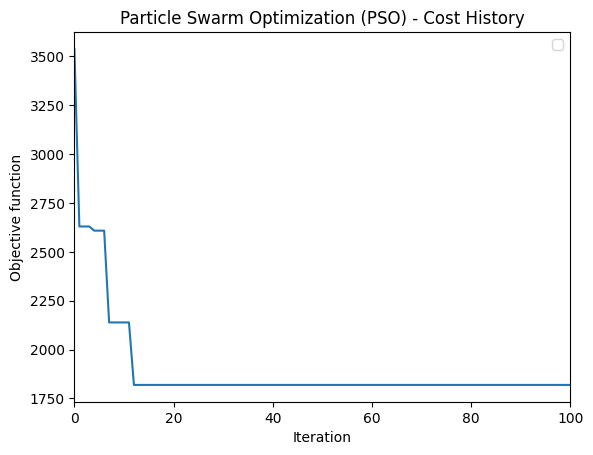

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 1818.8069080398955
Tempo de Convergência para a segunda etapa: 1.4082906246185303 segundos


In [84]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')


# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

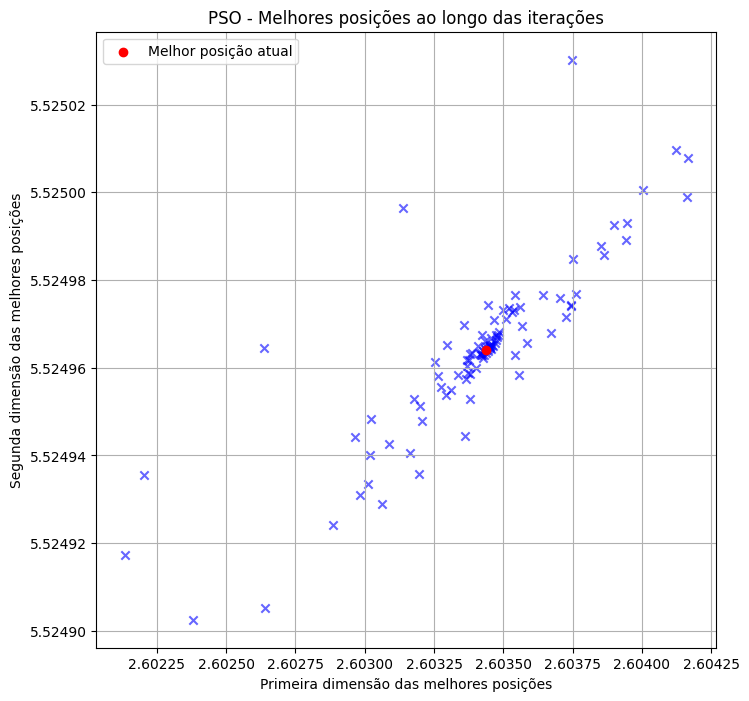

In [61]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [62]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [63]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [64]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,1479.320347,124.853663,1.998561,0.204234,0.007827,1.501749,5
1,2,339.841770,124.853663,1.998561,0.204234,0.010629,1.538298,9
2,3,1608.732899,124.853663,1.998561,0.204234,0.008020,1.539133,7
3,4,2287.475162,124.853663,1.998561,0.204234,0.011368,1.517747,7
4,5,1673.222643,124.853663,1.998561,0.204234,0.005658,1.507413,7
5,6,2022.213498,124.853663,1.998561,0.204234,0.008638,1.593264,10
6,7,807.218265,124.853663,1.998561,0.204234,0.008981,1.468226,4
7,8,1069.993804,124.853663,1.998561,0.204234,0.009973,1.130658,5
8,9,1221.651740,124.853663,1.998561,0.204234,0.007511,1.421273,4
9,10,1342.350823,124.853663,1.998561,0.204234,0.012248,1.416314,5


In [65]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        10 non-null     int64  
 1   Melhor_Custo                 10 non-null     float64
 2   Lambda                       10 non-null     float64
 3   Beta                         10 non-null     float64
 4   Theta                        10 non-null     float64
 5   Convergencia_Primeira_Etapa  10 non-null     float64
 6   Convergencia_Segunda_Etapa   10 non-null     float64
 7   Ciclos_MP                    10 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 768.0 bytes


In [66]:
resultado.describe()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000
mean,5.50000,1385.202095,124.853663,1.998561,2.042343e-01,0.009085,1.463408,6.300000
std,3.02765,569.253415,0.000000,0.000000,2.925695e-17,0.001987,0.128799,2.057507
min,1.00000,339.841770,124.853663,1.998561,2.042343e-01,0.005658,1.130658,4.000000
25%,3.25000,1107.908288,124.853663,1.998561,2.042343e-01,0.007875,1.433011,5.000000
50%,5.50000,1410.835585,124.853663,1.998561,2.042343e-01,0.008809,1.504581,6.000000
75%,7.75000,1657.100207,124.853663,1.998561,2.042343e-01,0.010465,1.533160,7.000000
max,10.00000,2287.475162,124.853663,1.998561,2.042343e-01,0.012248,1.593264,10.000000


In [67]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

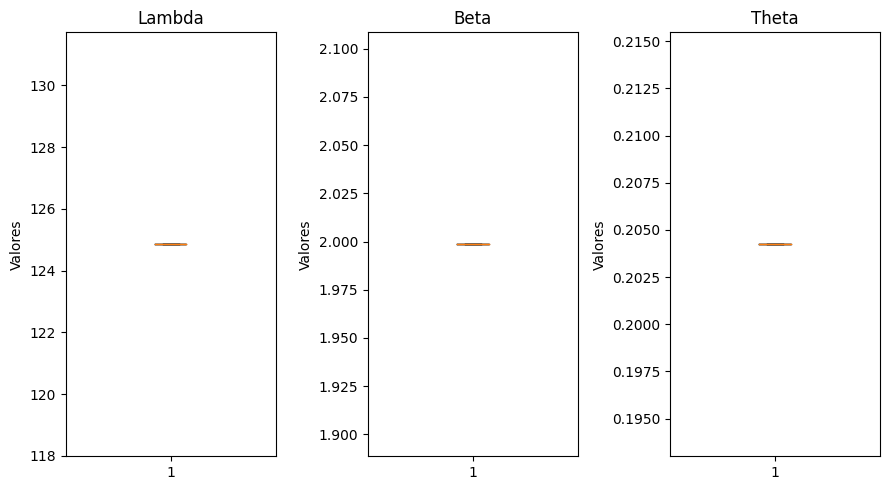

In [68]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

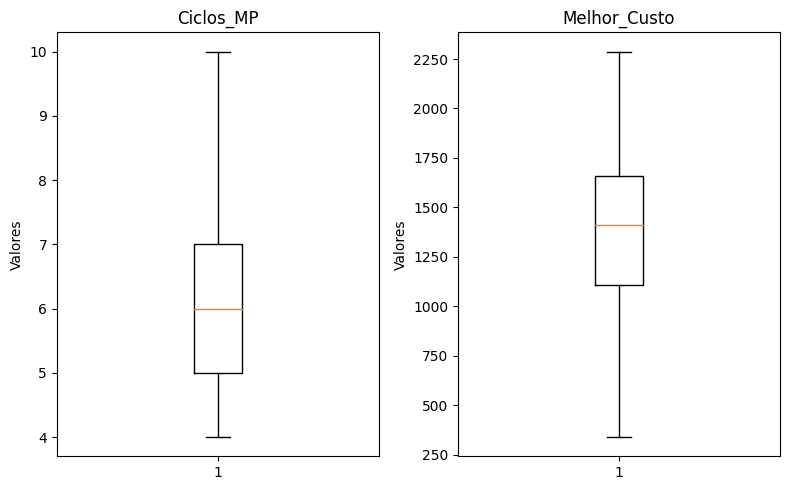

In [69]:
# Cria uma grafico para os parameros da segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_segunda_etapa):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

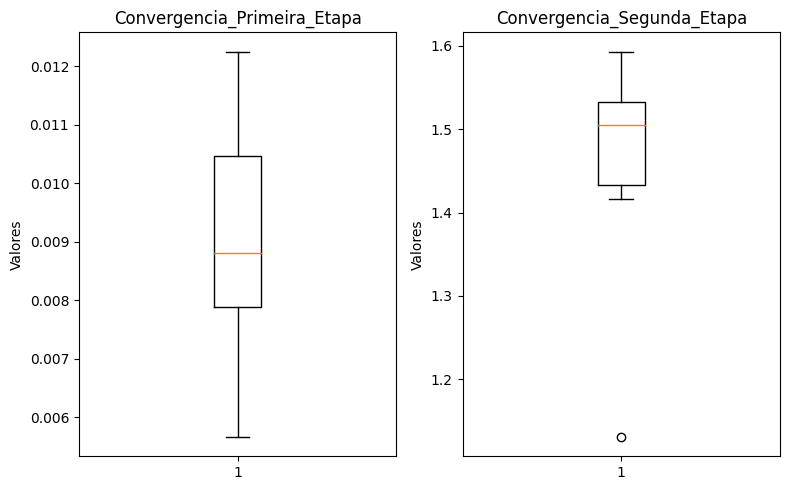

In [70]:
# Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(convergencia):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [71]:
# Arrays de tempos e severidade
Tempos = [
    [[0, 22, 74, 175, 247, 313, 426, 534, 640]],
    [[0, 16, 128, 168, 189, 260, 470, 532, 574]],
    [[0, 126, 209, 322, 447, 546, 620, 685]],
    [[0, 9, 179, 208, 365, 549, 621]],
    [[0, 77, 149, 166, 277, 386, 557]],
    [[0, 16, 193, 237, 300, 361, 404, 495, 554, 574]],
    [[0, 46, 79, 169, 304, 487, 642, 675]],
    [[0, 158, 362, 412, 469, 482, 539, 617, 702]],
    [[0, 112, 173, 205, 421, 550, 711]],
    [[0, 63, 185, 370, 593, 622, 647]],
]

severidade = [
    [[0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5]],
    [[0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25]],
    [[0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5]],
    [[0.25, 0.75, 0.25, 0.5, 0.5, 0.25]],
    [[0.5, 0.5, 0.5, 0.5, 0.25, 0.25]],
    [[0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5]],
    [[0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]],
    [[0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5]],
    [[0.25, 0.25, 0.5, 0.25, 0.25, 0.5]],
    [[0.75, 0.75, 0.5, 0.75, 0.5, 0.25]],
]

# # Verifica se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
#         file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [72]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,"352, 417, 534, 592, 642","0.5, 0.25, 0.5, 0.5, 0.5"
1,"98, 158, 225, 244, 320, 434, 491, 563, 602","0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5"
2,"168, 227, 272, 358, 463, 531, 616","0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5"
3,"158, 184, 341, 381, 420, 594, 621","0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5"
4,"88, 130, 254, 370, 432, 573, 655","0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5"
5,"26, 38, 76, 103, 202, 293, 397, 450, 547, 618","0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, ..."
6,"101, 224, 370, 436","0.25, 0.5, 0.5, 0.25"
7,"95, 210, 329, 383, 534","0.5, 0.5, 0.25, 0.25, 0.25"
8,"35, 245, 595, 647","0.75, 0.5, 0.5, 0.25"
9,"161, 312, 415, 622, 689","0.5, 0.75, 0.5, 0.5, 0.5"


In [73]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


In [74]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,10,10
top,"352, 417, 534, 592, 642","0.5, 0.25, 0.5, 0.5, 0.5"
freq,1,1
